In [1]:
import pandas as pd
import warnings
warnings.simplefilter('ignore') # отключим предупреждения Anaconda
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc
import random
import optuna

In [2]:
data = pd.read_csv('train.csv')

# EDA

In [3]:
#В целом посмотрим на данные
data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


- **Id**: общий идентификатор
- **Product ID** : номер оборудования 
- **Type**: Тип оборудования
- **Air temperature**: температура воздуха оборудования	
- **Process temperature**: температура процесса
- **rotational speed [rpm]**: скорость вращения 
- **Torque [Nm]**: крутящийся момент 
- **Tool wear [min]**: Износ инструмента
- **Machine failure**: -**Сбой оборудования**-
- **WF, HDF, PWF, OSF, RNF**: прочие данные (бинарные) влияющие на останов оборудования


In [4]:
#Посмотрим на пропуски и типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [5]:
#статистики всех признаков
data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#смотрим на не числовые признаки
data.describe(include=['object', 'bool'])

,Product ID,Type
count,136429,136429
unique,9976,3
top,L53257,L
freq,139,95354


In [7]:
#посмотрим на дубликаты
data.duplicated().sum()


0

In [8]:
data['Product ID']

0         L50096
1         M20343
2         L49454
3         L53355
4         M24050
           ...  
136424    M22284
136425    H38017
136426    L54690
136427    L53876
136428    L47937
Name: Product ID, Length: 136429, dtype: object

#### Предварительные выводы:
- дубликатов нет
- повторов нет
- Тип данных в порядке
- По признакам предварительно (type - через OneHotEncoding)
- Повтор Type в наименование Product ID
- уникальных значений Product_ID=9976, Значения повторяются 1 до 139 раз. Можем предположить, что убрав из кода тип Type, и использовать признак вещественный

### 1) Построим распределение числовых типов данных
- построим гистограмму плотности
- построим  диаграмму размаха
- Сравним гистограммы плотности числовых данных в связи с таргетом "Machine failure"

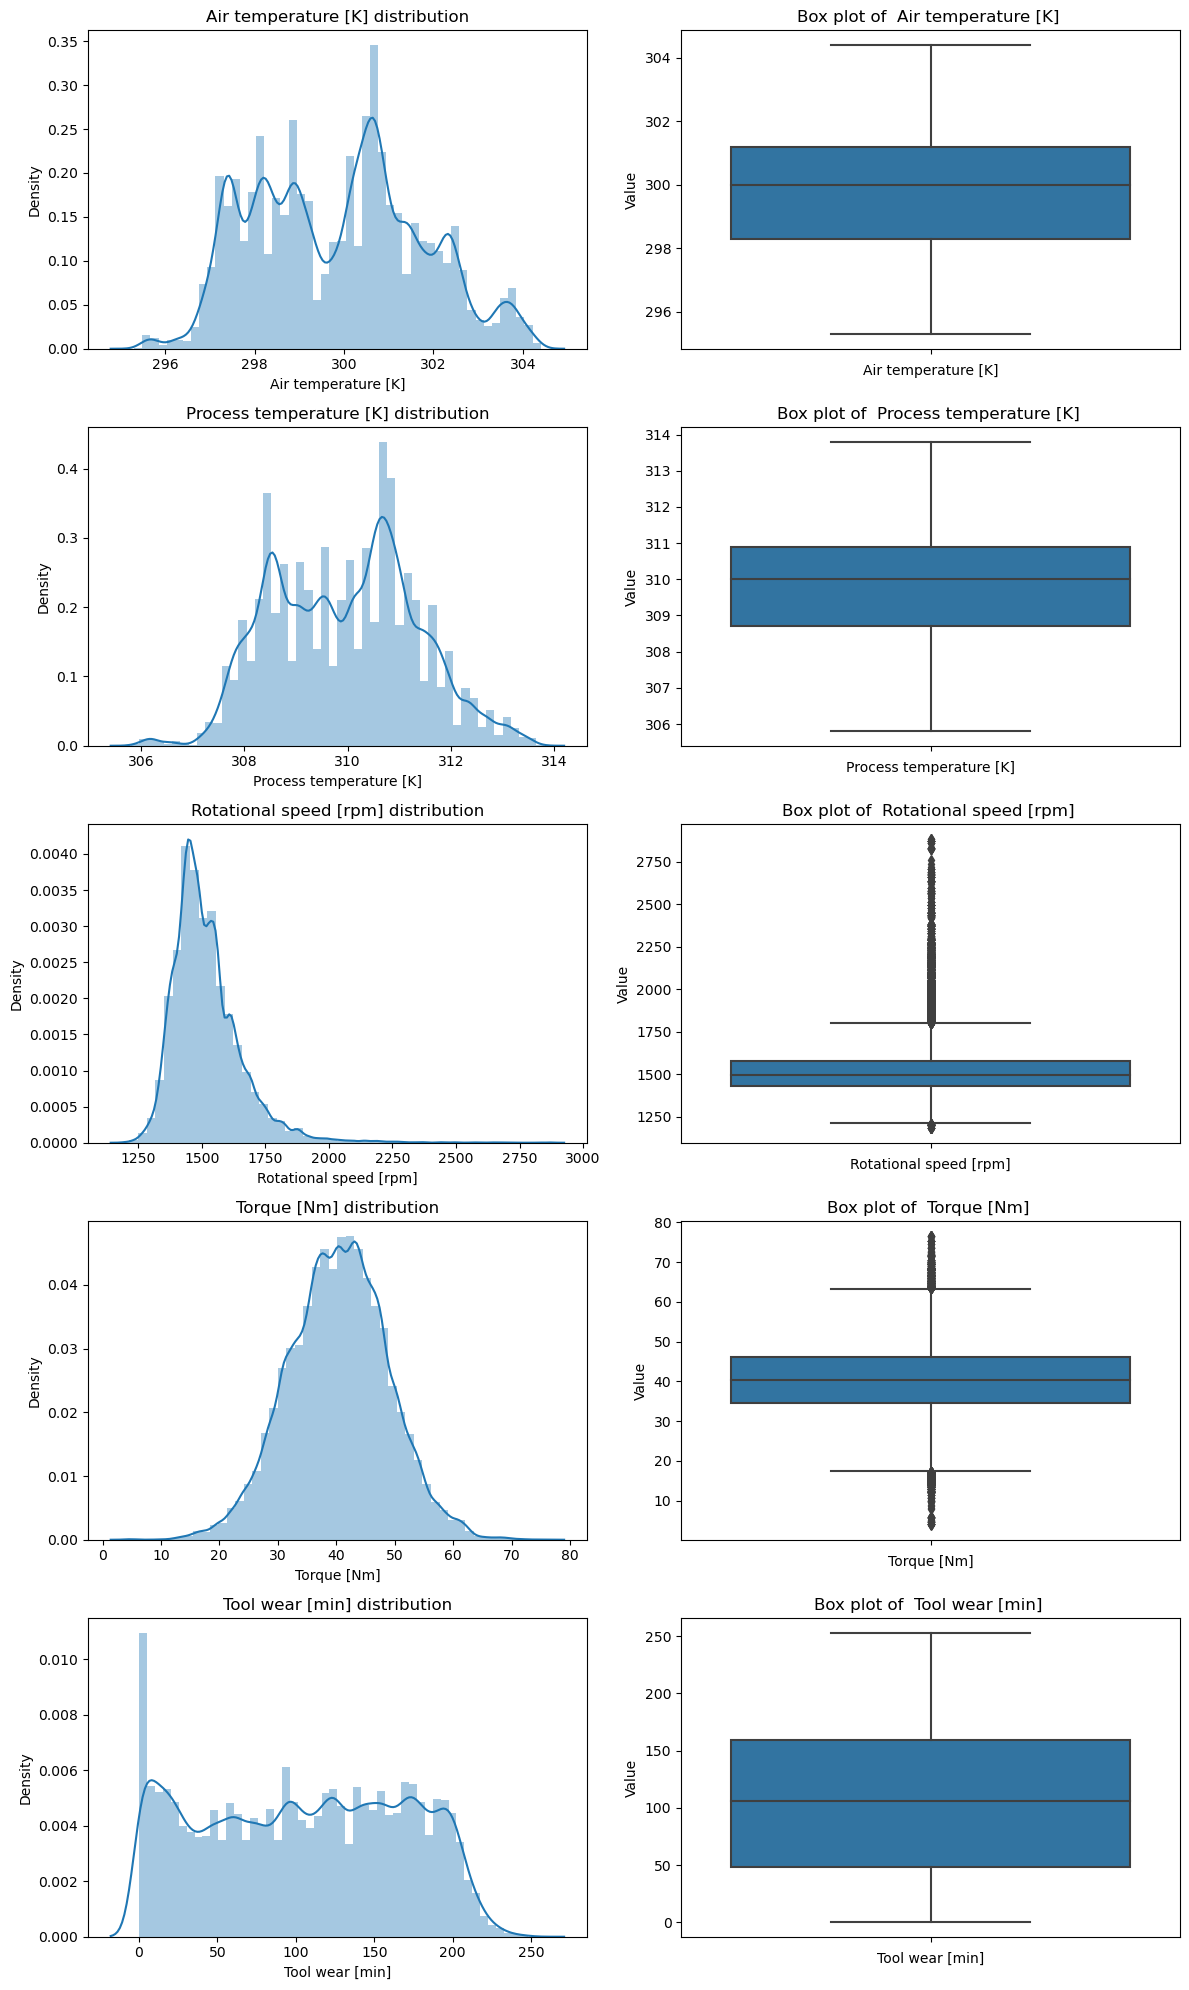

In [9]:
num_col = ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
           'Tool wear [min]']

def plot_histograms(num_col, rows, cols):

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,20))
    for i, column in enumerate(num_col):
        # Histogram
        ax = axes[i,0]
        sns.distplot(data[column], ax=ax, kde=True)
        
        ax.set_title(f'{column} distribution')
        
        # Box plot
        ax = axes[i,1]
        sns.boxplot(data = data, y=data[column], ax=ax)
        ax.set_title(f'Box plot of  {column} ')
        
        ax.set_xlabel(column)
        ax.set_ylabel('Value')

        
    plt.tight_layout()
    plt.show()
        
plot_histograms(num_col, len(num_col), 2)

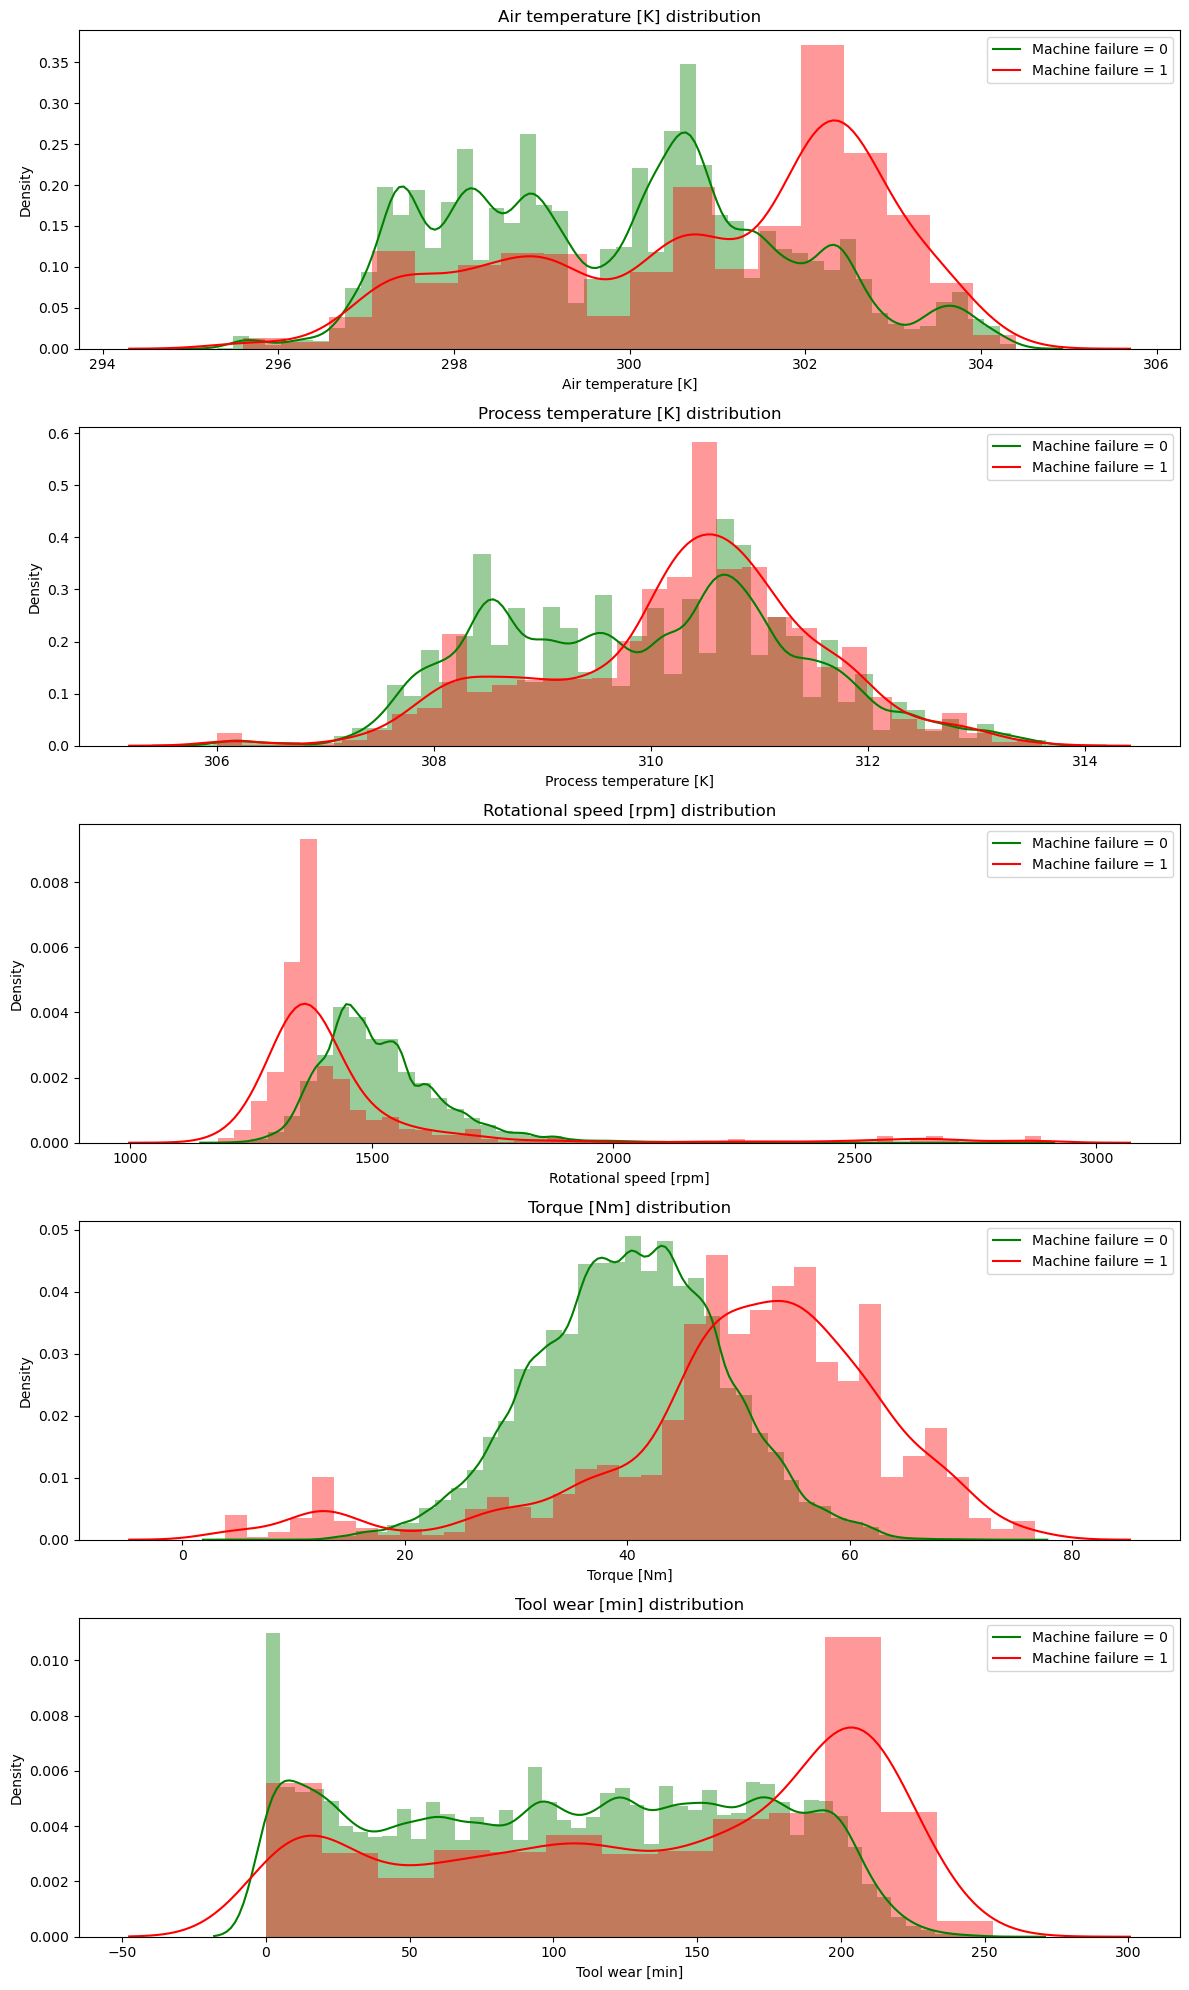

In [10]:
def plot_histograms(num_col, rows, cols):

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,20))
    for i, column in enumerate(num_col):
        
        # Histogram  'Machine failure' ==== 0
        ax = axes[i]
        sns.distplot(data[data['Machine failure'] == 0][column], ax=ax, kde=True,color='green')
        
       # Histogram  'Machine failure' ==== 1
        sns.distplot(data[data['Machine failure'] == 1][column], ax=ax,color='red')
        ax.set_title(f'{column} distribution')
        ax.legend(['Machine failure = 0', 'Machine failure = 1'])
    

        
    plt.tight_layout()
    plt.show()
        
plot_histograms(num_col, len(num_col), 1)

### Выводы по данным вещественных чисел
- **Air temperature [K]** - распределение сложно назвать нормальным, но стремится к нему, как таковых выбросов нет. Значения 'Machine failure' (далее таргет/отказы) смещены в правую сторону, в зону больших температур
- **Process temperature [K]** - похожая величина предыдущей, скорей всего есть сильная корреляция (проверим позже), также отказы смещены в сторону больших температур
- **Rotational speed [rpm]** - распределение с тяжелым хвостом , стремится к логнормальному. Отказы здесь наоборот смещены к меньшему значению Rotational speed
- **Torque [Nm]** - нормальное распределение. Отказы распределены менее нормально (виднеется тяжелый левый хвост), также данные по отказам смещены правее, что их также выделяет
- **Tool wear [min]** - распределение равномерное. Но присутствует некая взаимосвязь, что при больших значениях вероятность отказа больше

### 2) Построим распределение категориальных (type) и бинарных данных

- построим гистограммы
- Сравним гистограммы в связи таргетом "Machine failure"

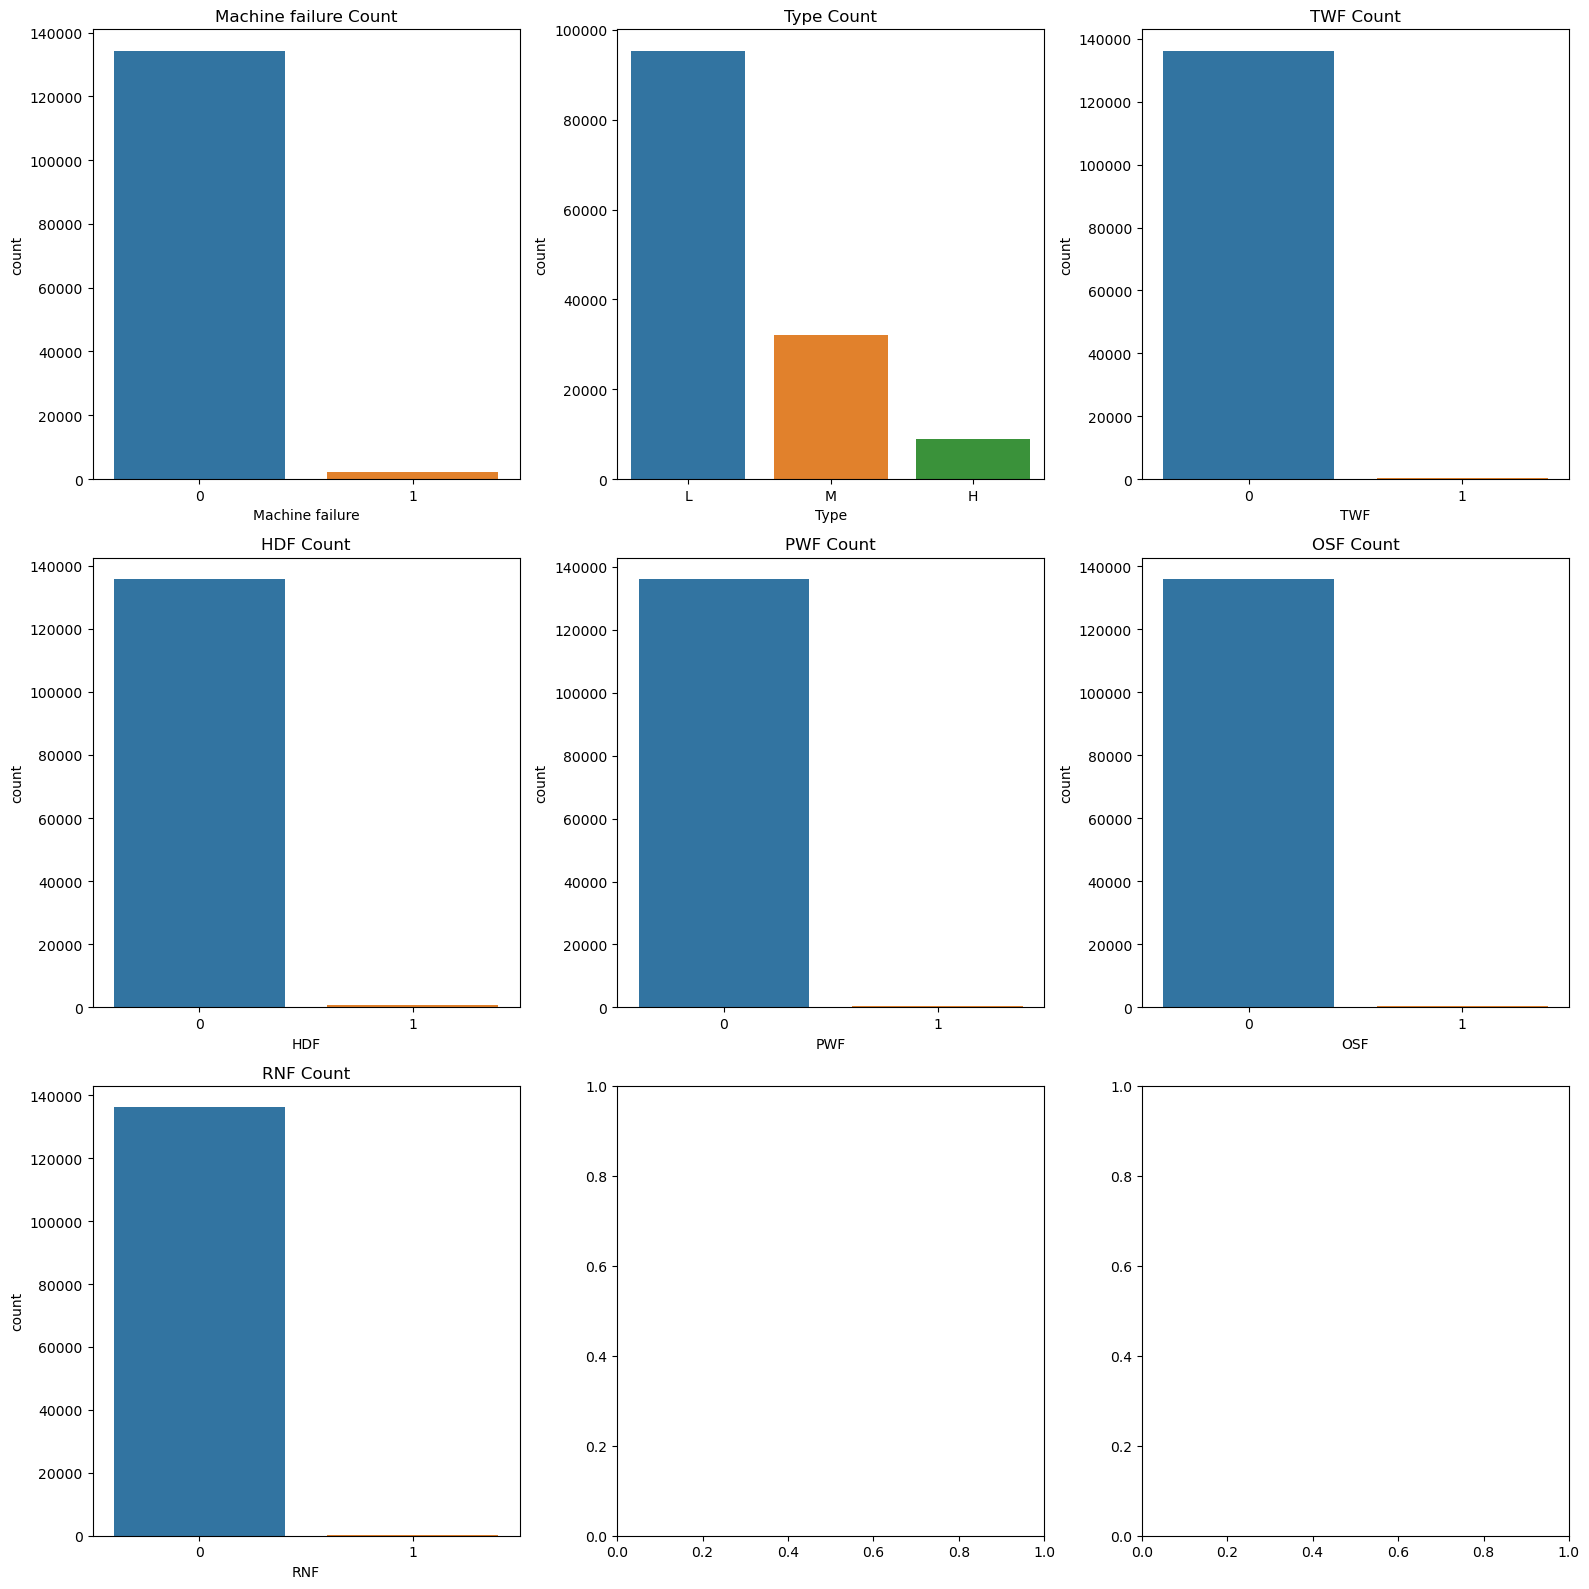

In [11]:
cat_col = ['Machine failure', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

def plot_histograms(num_col, rows, cols):
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16,16))
    ax = ax.flatten()
       
    for i, column in enumerate(num_col):
        # Histogram
        sns.countplot(x=data[column], ax=ax[i])
        ax[i].set_title(f'{column} Count')
      
    plt.tight_layout()
    plt.show()
        
plot_histograms(cat_col, 3, 3)

In [12]:
data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


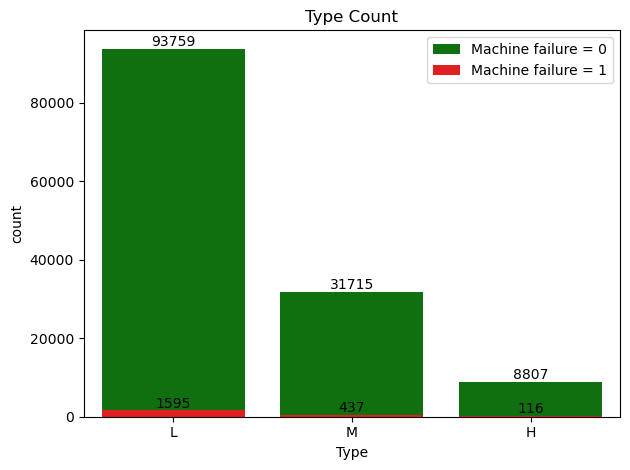

In [13]:
def plot_histograms(cat_col, rows, cols):
    # Histogram  'Machine failure' ==== 0
    ax = sns.countplot(data[data['Machine failure'] == 0]['Type'], color='green')
        
    # Histogram  'Machine failure' ==== 1
    sns.countplot(data[data['Machine failure'] == 1]['Type'],color='red')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
    ax.set_title(f'Type Count')
    ax.legend(['Machine failure = 0', 'Machine failure = 1'])
    

        
    plt.tight_layout()
    plt.show()



        
#plot_histograms(cat_col, 3, 3)
plot_histograms(cat_col[1:], len(cat_col[1:]), 1)

In [14]:
print(f"Общий дисбаланс классов {round((data[data['Machine failure'] == 0].shape[0])/(data[data['Machine failure'] == 1].shape[0]),2)}")


Общий дисбаланс классов 62.51


### Выводы по данным ,категориальным признакам
- Мы имеем большой дисбаланс классов в 62 раза
- пропорциональность сохраняется по всем бинарным признаками и в том числе категориальным type

<AxesSubplot:>

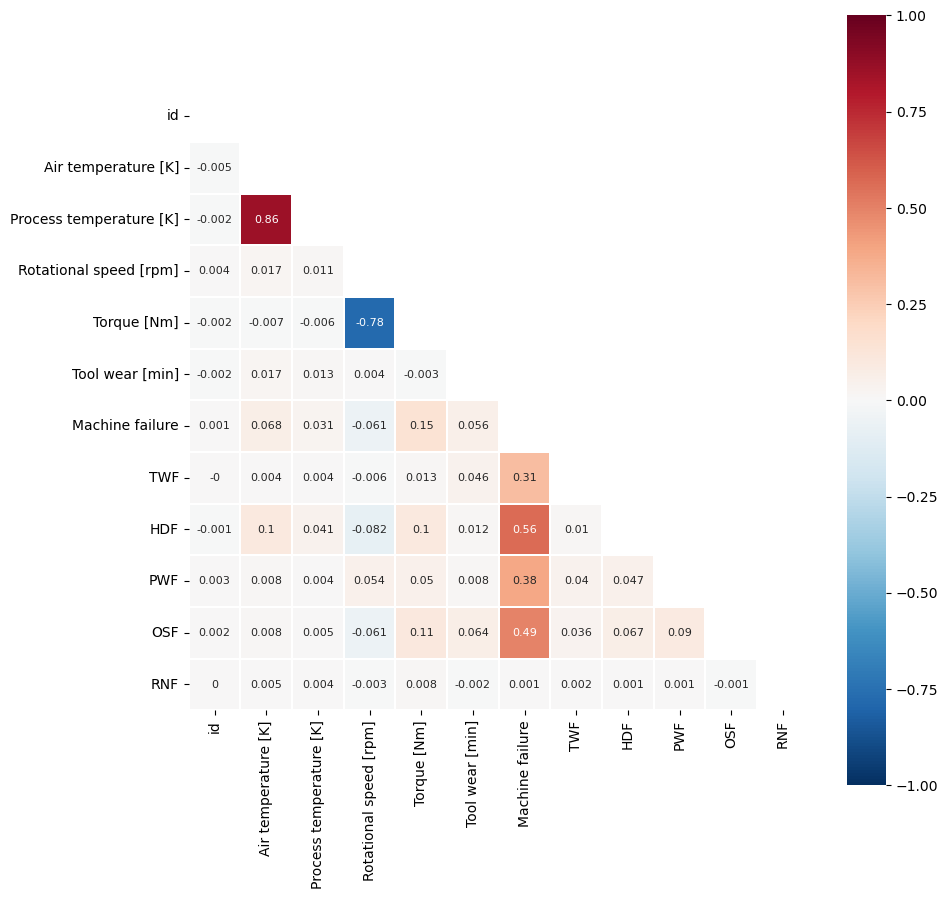

In [15]:
corr_matrix = data.corr().round(3)
colormap = plt.cm.RdBu_r
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix,linewidths=0.1, vmax=1.0, vmin=-1.0, annot = True, 
            linecolor='white',cmap= colormap, square = True, fmt='.2g', annot_kws={"size": 8}, mask = mask)

### Выводы корреляции
- Proc temp достаточно сильно коррелирует с Air temp
- Все бинарные данные имеют корреляцию с таргетом, больше чем все остальные признаки

### Preprocessing data

- 1) Product ID - удалим
- 2) Масштабируем наши числовые данные данные
- 3) Пообучаем модель на разных моделях, поищим лучшеи гиперпараметры
- 4) Включим в ход features engineering (создание признаков на основании зависимости признаков имеющихся) ) 

In [16]:
df = data.copy()
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [17]:
1# Изменим наименование столбцов, чтобы "некоторые" модели не ругались
df = df.rename(columns = {'Product ID':'Product_id', 'Air temperature [K]':'Air_temp','Process temperature [K]':'Proc_temp', 'Rotational speed [rpm]': 'Rot_speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool_wear', 'Machine failure':'Target' })
2# Удалим лишний столбц id
df = df.drop(columns=['id', 'Product_id'])



In [18]:
4# type через one-hot-encoding
one_hot = pd.get_dummies(df['Type'], prefix='Type', drop_first=True)
df = pd.concat((df.drop('Type', axis=1), one_hot), axis=1)

In [19]:
#5 Промаштабируем наши числовые данные
scaler = StandardScaler()
df[['Air_temp','Proc_temp','Rot_speed','Torque','Tool_wear']] = scaler.fit_transform(df[['Air_temp','Proc_temp','Rot_speed','Torque','Tool_wear']])

In [20]:
df.head()

,Air_temp,Proc_temp,Rot_speed,Torque,Tool_wear,Target,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,0,1,0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0,0,1
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,0,1,0
3,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,0,1,0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0,0,1


<AxesSubplot:>

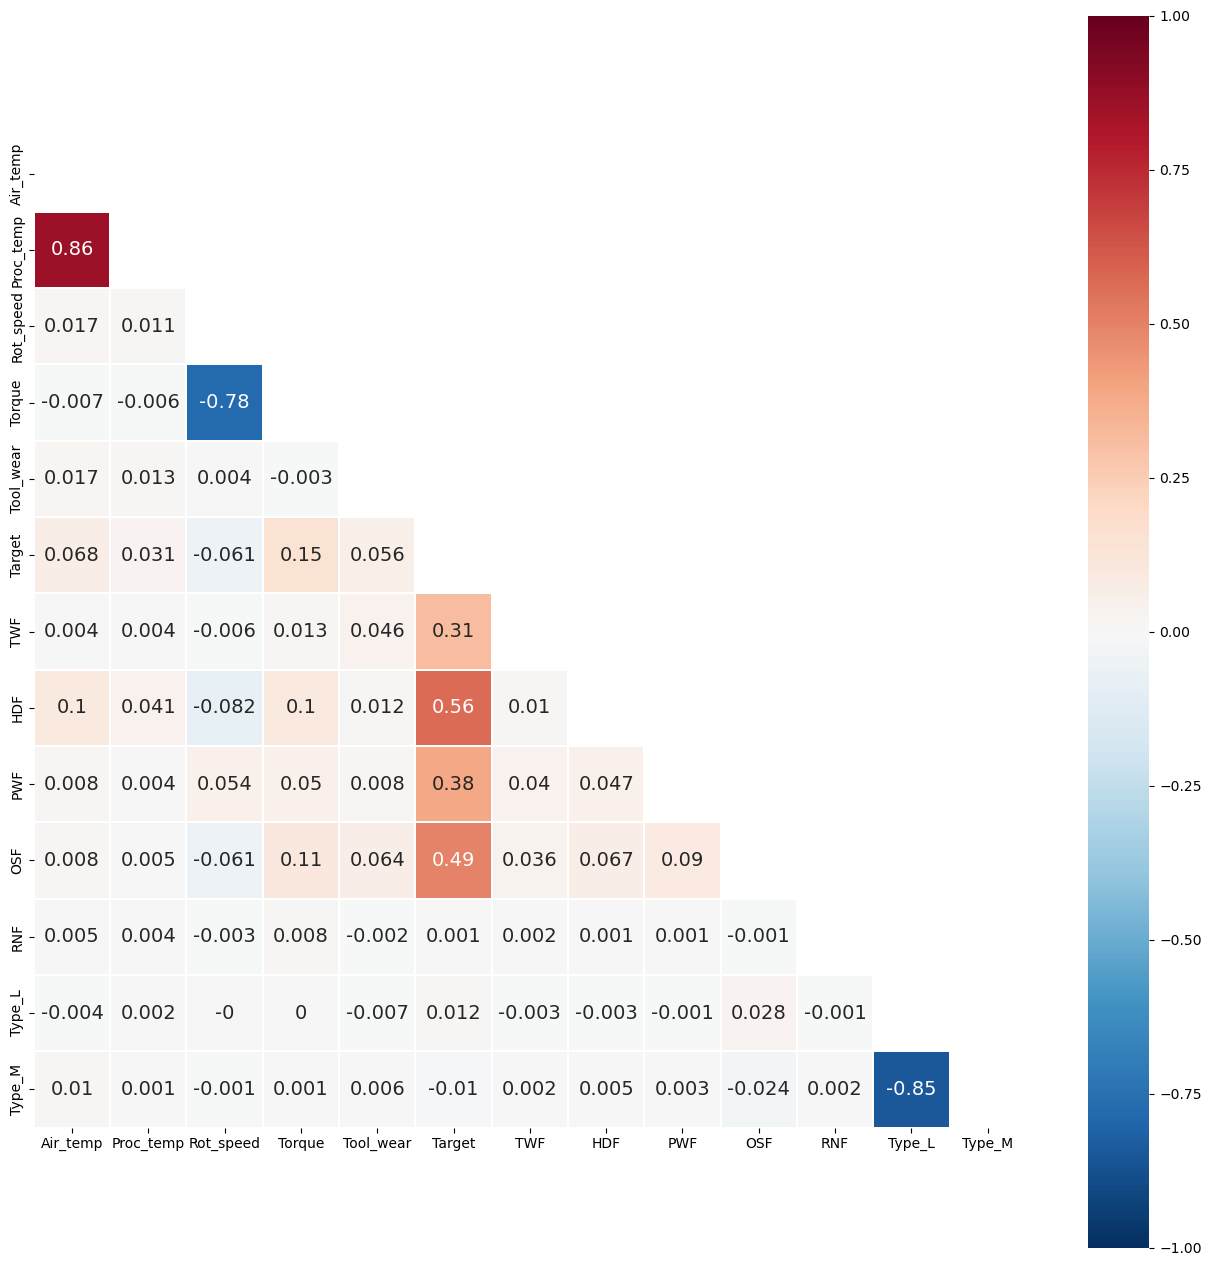

In [21]:
corr_matrix = df.corr().round(3)
colormap = plt.cm.RdBu_r
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize = (16,16))
sns.heatmap(corr_matrix,linewidths=0.1, vmax=1.0, vmin=-1.0, annot = True, 
            linecolor='white',cmap= colormap, square = True, fmt='.2g', annot_kws={"size": 14}, mask = mask)

### Primary training - Basic Models

In [23]:
### Разделим данные на объекты и ответы
X = df.drop(['Target'], axis=1)
y = df['Target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    shuffle=True, #предварительно посортировали по дате
                                                    test_size=0.2)

#### 1) Сформируем случайный таргет несколько раз (100 раз), замерим качество и усредним
***Смотреть будем на метрики ROC_AUC, PR_AUC***

In [25]:

score = {'random_roc_auc':[],'random_pr_auc':[]}

for i in range(1,100):
    r = [random.randint(0, 1) for _ in range(len(X_test))]
    score['random_roc_auc'].append(roc_auc_score(y_test, r))
    score['random_pr_auc'].append(average_precision_score(y_test, r))
    
print(f'Среднее качество рандомно предсказанных данных на ROC_AUC = {np.mean(score["random_roc_auc"]):.3f}')
print(f'Среднее качество рандомно предсказанных данных на PR_AUC = {np.mean(score["random_pr_auc"]):.3f}')


Среднее качество рандомно предсказанных данных на ROC_AUC = 0.501
Среднее качество рандомно предсказанных данных на PR_AUC = 0.016


#### 3) Рассмотрим, вариант без машинного обучения

1) Представим что мы принимаем решения исходя из сильно скоррелирвоанных данных к таргету ( бинарных метрик: [ 'TWF', 'HDF', 'PWF', 'OSF'])  
2) Если у объекта в одном из бинарных признаков 1 - считаем объект отказом
<br/>3) Проверим на тренировочных и тестовых данных, заранее перемешанных

In [26]:
strong_correlation_col = [ 'TWF', 'HDF', 'PWF', 'OSF']
Target_Base_train = X_train[strong_correlation_col].apply(lambda row: 1 if any(row) else 0, axis=1)
Target_Base_test = X_test[strong_correlation_col].apply(lambda row: 1 if any(row) else 0, axis=1)

score['random_roc_auc'].append(roc_auc_score(y_test, r))
score['random_pr_auc'].append(average_precision_score(y_test, r))
    

print(f'Качество ROC_AUC базовой модели на тесте по бинарным признакам = {roc_auc_score(y_test, Target_Base_test):.3f}')
print()
print(f'Качество PR_AUC базовой модели на тесте по бинарным признакам = {average_precision_score(y_test, Target_Base_test):.3f}')

Качество ROC_AUC базовой модели на тесте по бинарным признакам = 0.884

Качество PR_AUC базовой модели на тесте по бинарным признакам = 0.764


### 3) Обучим модели LogReg и CatBoost

In [19]:
model_LR = LogisticRegression(random_state=42)
model_CB = CatBoostClassifier(random_state=42, verbose=False)

In [20]:
#Небольшая функция: принимает модель и данные для обучения и тестирования. 
#На выход выдает предсказание и результаты на трейне и тесте

def train_classifier(clf,x_train,y_train,x_test,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    score_train = roc_auc_score(y_train, clf.predict_proba(x_train)[:,1])
    score_test  = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
    
    score_train_PR = average_precision_score(y_train, clf.predict_proba(x_train)[:,1])
    score_test_PR  = average_precision_score(y_test, clf.predict_proba(x_test)[:,1])
    
    
    return score_train, score_test, score_train_PR, score_test_PR

In [100]:
ROC_AUC_LR_train, ROC_AUC_LR_test, ROC_PR_LR_train, ROC_PR_LR_test = train_classifier(model_LR,X_train,y_train,X_test,y_test)
print(f'ROC_AUC_model_LR на train {ROC_AUC_LR_train:.3f}')
print(f'ROC_AUC_model_LR на test {ROC_AUC_LR_test:.3f}')
print(f'PR_AUC_model_LR на train {ROC_PR_LR_train:.3f}')
print(f'PR_AUC_model_LR на test {ROC_PR_LR_test:.3f}')

ROC_AUC_model_LR на train 0.937
ROC_AUC_model_LR на test 0.937
PR_AUC_model_LR на train 0.815
PR_AUC_model_LR на test 0.812


In [101]:
ROC_AUC_CB_train, ROC_AUC_CB_test, ROC_PR_CB_train, ROC_PR_CB_test = train_classifier(model_CB,X_train,y_train,X_test,y_test)
print(f'ROC_AUC_model_CB на train {ROC_AUC_CB_train:.3f}')
print(f'ROC_AUC_model_CB на test {ROC_AUC_CB_test:.3f}')
print(f'PR_AUC_model_CB на train {ROC_PR_CB_train:.3f}')
print(f'PR_AUC_model_CB на test {ROC_PR_CB_test:.3f}')

ROC_AUC_model_CB на train 0.991
ROC_AUC_model_CB на test 0.958
PR_AUC_model_CB на train 0.935
PR_AUC_model_CB на test 0.828


### 3) Обучим модели - классическая LogReg и CatBoost c Balanced classes 

In [102]:
model_LR_B = LogisticRegression(random_state=42, class_weight='balanced' )
model_CB_B = CatBoostClassifier(random_state=42, verbose=False, auto_class_weights='Balanced' )

In [103]:
ROC_AUC_LR_train_B, ROC_AUC_LR_test_B, ROC_PR_LR_train_B, ROC_PR_LR_test_B = train_classifier(model_LR_B,X_train,y_train,X_test,y_test)
print(f'ROC_AUC_model_LR with B на train {ROC_AUC_LR_train_B:.3f}')
print(f'ROC_AUC_model_LR with B на test {ROC_AUC_LR_test_B:.3f}')
print(f'PR_AUC_model_LR with B на train {ROC_PR_LR_train_B:.3f}')
print(f'PR_AUC_model_LR with B на test {ROC_PR_LR_test_B:.3f}')

ROC_AUC_model_LR with B на train 0.938
ROC_AUC_model_LR with B на test 0.938
PR_AUC_model_LR with B на train 0.814
PR_AUC_model_LR with B на test 0.809


In [104]:
ROC_AUC_CB_train_B, ROC_AUC_CB_test_B, ROC_PR_CB_train_B, ROC_PR_CB_test_B = train_classifier(model_CB_B,X_train,y_train,X_test,y_test)
print(f'ROC_AUC_model_CB with B на train {ROC_AUC_CB_train_B:.3f}')
print(f'ROC_AUC_model_CB with B на test {ROC_AUC_CB_test_B:.3f}')
print(f'PR_AUC_model_CB with B на train {ROC_PR_CB_train_B:.3f}')
print(f'PR_AUC_model_CB with B на test {ROC_PR_CB_test_B:.3f}')

ROC_AUC_model_CB with B на train 1.000
ROC_AUC_model_CB with B на test 0.956
PR_AUC_model_CB with B на train 0.988
PR_AUC_model_CB with B на test 0.831


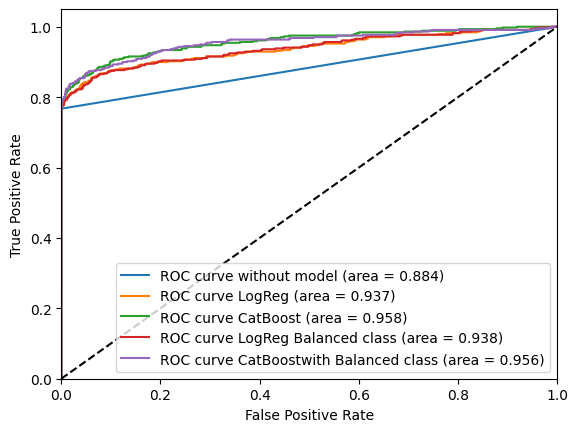

In [105]:

# Вычисляем значения FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, Target_Base_test)
fp_LR, tpr_LR, thresholds_LR = roc_curve(y_test, model_LR.predict_proba(X_test)[:,1])
fp_CB, tpr_CB, thresholds_CB = roc_curve(y_test, model_CB.predict_proba(X_test)[:,1])
fp_LR_B, tpr_LR_B, thresholds_LR_B = roc_curve(y_test, model_LR_B.predict_proba(X_test)[:,1])
fp_CB_B, tpr_CB_B, thresholds_CB_B = roc_curve(y_test, model_CB_B.predict_proba(X_test)[:,1])
# Вычисляем значение площади под кривой ROC-AUC
roc_auc,roc_auc_LR,roc_auc_CB,roc_auc_LR_B,roc_auc_CB_B = auc(fpr, tpr), auc(fp_LR, tpr_LR), auc(fp_CB, tpr_CB), auc(fp_LR_B, tpr_LR_B), auc(fp_CB_B, tpr_CB_B)

# Рисуем график ROC-AUC
plt.plot(fpr, tpr, label='ROC curve without model (area = %0.3f)' % roc_auc)
plt.plot(fp_LR, tpr_LR, label='ROC curve LogReg (area = %0.3f)' % roc_auc_LR)
plt.plot(fp_CB, tpr_CB, label='ROC curve CatBoost (area = %0.3f)' % roc_auc_CB)
plt.plot(fp_LR_B, tpr_LR_B, label='ROC curve LogReg Balanced class (area = %0.3f)' % roc_auc_LR_B)
plt.plot(fp_CB_B, tpr_CB_B, label='ROC curve CatBoostwith Balanced class (area = %0.3f)' % roc_auc_CB_B)
plt.plot([0, 1], [0, 1], 'k--')  # Случайная модель
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


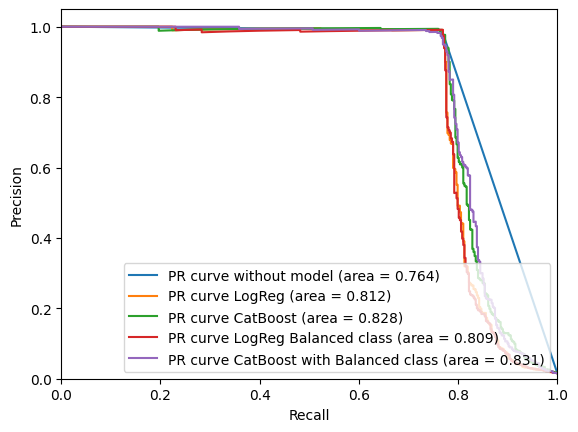

In [106]:
# Вычисляем значения точности и полноты

precision_rand, recall_rand, thresholds_rand = precision_recall_curve(y_test, Target_Base_test)
precision, recall, thresholds = precision_recall_curve(y_test, Target_Base_test)
precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_test, model_LR.predict_proba(X_test)[:,1])
precision_CB, recall_CB, thresholds_CB = precision_recall_curve(y_test, model_CB.predict_proba(X_test)[:,1])
precision_LR_B, recall_LR_B, thresholds_LR_B = precision_recall_curve(y_test, model_LR_B.predict_proba(X_test)[:,1])
precision_CB_B, recall_CB_B, thresholds_CB_B = precision_recall_curve(y_test, model_CB_B.predict_proba(X_test)[:,1])

# Вычисляем значение площади под кривой ROC-PR
pr_auc, pr_auc_LR, pr_auc_CB, pr_auc_LR_B, pr_auc_CB_B = average_precision_score(y_test, Target_Base_test), average_precision_score(y_test, model_LR.predict_proba(X_test)[:,1]), average_precision_score(y_test, model_CB.predict_proba(X_test)[:,1]), average_precision_score(y_test, model_LR_B.predict_proba(X_test)[:,1]), average_precision_score(y_test, model_CB_B.predict_proba(X_test)[:,1])
# Рисуем график ROC-PR

plt.plot(recall, precision, label='PR curve without model (area = %0.3f)' % pr_auc)
plt.plot(recall_LR, precision_LR, label='PR curve LogReg (area = %0.3f)' % pr_auc_LR)
plt.plot(recall_CB, precision_CB, label='PR curve CatBoost (area = %0.3f)' % pr_auc_CB)
plt.plot(recall_LR_B, precision_LR_B, label='PR curve LogReg Balanced class (area = %0.3f)' % pr_auc_LR_B)
plt.plot(recall_CB_B, precision_CB_B, label='PR curve CatBoost with Balanced class (area = %0.3f)' % pr_auc_CB_B)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.show()


### Топ 5 моделей с дефолтными параметрами:

|**Models**|**ROC_AUC**|**PR_AUC**
|:---|:---:|:---:|
|Без обучения (по данным, коррелирующие с таргетом отказа)|0.884|0.764|
|Log Reg|0.937|0.812|
|**CatBoost**|**0.957**|**0.831**|

## Рассмотрим большее колличество моделей на дефолтных параметрах + добавим перемешивание данных перекрестной проверкой 

In [22]:
models = {
    'LR': LogisticRegression(), 
    'CB': CatBoostClassifier(verbose = False, random_state = 42, auto_class_weights='Balanced'),
    'LGBM': LGBMClassifier(is_unbalance = True, random_state = 42, metric = 'auc'),
    'XGBC': XGBClassifier(eval_metric='auc',random_state = 42,objective="binary:logistic"),
    'DT' : DecisionTreeClassifier(random_state = 42),
    'RFC': RandomForestClassifier(random_state = 42, class_weight='balanced'),
    'BRF': BalancedRandomForestClassifier(random_state=42),
    'HGB': HistGradientBoostingClassifier(class_weight='balanced', random_state = 42)
}

In [23]:
from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
gren = Style.BRIGHT + Fore.GREEN
res = Style.RESET_ALL

In [110]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
cv_splits = list(cv.split(X,y))

for i in models:
    scores_test_ROC = []
    scores_test_PR = []
    print(f'{blu} Model {i}')
    for j, (train_index, test_index) in enumerate(cv_splits):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        score_train_ROC, score_test_ROC, score_train_PR, score_test_PR  = train_classifier(models[i], X_train_fold, y_train_fold, X_test_fold, y_test_fold)        
        
        scores_test_ROC.append(round(score_test_ROC,3))
        scores_test_PR.append(round(score_test_PR,3))
    
    print(f'ROC_AUC {blu}{scores_test_ROC}')
    print(f'ROC_PR {blu}{scores_test_PR}')

    
    if (np.mean(scores_test_ROC)>0.93) & (np.mean(scores_test_PR)>0.81):
            print(f'{gren} Mean ROC_AUC is {np.mean(scores_test_ROC):.3f}')
            print(f'{gren} Mean POC_PR is {np.mean(scores_test_PR):.3f}')
            print('_'*40)
    else:
            print(f"{red} Not a good model with ROC_AUC = {np.mean(scores_test_ROC):.3f}")
            print(f'{red} Not a good model with ROC_PR = {np.mean(scores_test_PR):.3f}')
            print('_'*40)
    
    

 Model LR
ROC_AUC [0.931, 0.938, 0.943, 0.934, 0.934]
ROC_PR [0.799, 0.819, 0.847, 0.787, 0.817]
 Mean ROC_AUC is 0.936
 Mean POC_PR is 0.814
________________________________________
 Model CB
ROC_AUC [0.96, 0.947, 0.963, 0.953, 0.94]
ROC_PR [0.829, 0.826, 0.863, 0.815, 0.821]
 Mean ROC_AUC is 0.953
 Mean POC_PR is 0.831
________________________________________
 Model LGBM
ROC_AUC [0.955, 0.952, 0.963, 0.954, 0.948]
ROC_PR [0.83, 0.833, 0.864, 0.819, 0.829]
 Mean ROC_AUC is 0.954
 Mean POC_PR is 0.835
________________________________________
 Model XGBC
ROC_AUC [0.961, 0.954, 0.967, 0.958, 0.953]
ROC_PR [0.837, 0.84, 0.865, 0.82, 0.838]
 Mean ROC_AUC is 0.959
 Mean POC_PR is 0.840
________________________________________
 Model DT
ROC_AUC [0.883, 0.892, 0.904, 0.876, 0.885]
ROC_PR [0.55, 0.563, 0.592, 0.579, 0.564]
 Not a good model with ROC_AUC = 0.888
 Not a good model with ROC_PR = 0.570
________________________________________
 Model RFC
ROC_AUC [0.942, 0.938, 0.95, 0.939, 0.939]
R

### Топ 5 моделей с дефолтными параметрами:

|**№**|**Models**|**ROC_AUC**|**PR_AUC**|
|:---|:---|:---:|:---:|
|0|Без обучения (по данным, коррелирующие с таргетом отказа)|0.884|0.764|
|**1**|**BalancedRandomForestClassifier**|**0.964**|0.828|
|**2**|HistGradientBoostingClassifie*|0.961|0.834|
|**3**|XGBClassifier|0.959|**0.837**|
|**4**|LGBMClassifier|0.954|**0.838**|
|**5**|CatBoost|0.953|0.835|

**Используя модели машинного обучения прироста ROC-AUC и PR-AUC 8-10 процентов**
<br/> В Целом, нам важно зацепить как можно больше объектов положительного класса (то есть отказы) и при этом ранжировать их в порядке вероятности отказов. Нам не так критично, если мы зацепим объекты отрицательного класса ( не отказ). Следовательно, мы можем полностью полагаться на метрику ROC_AUC.

### 1 ) BalancedRandomForestClassifier +Optuna

In [112]:
%%time
def brf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ["sqrt", "log2", None])
    }

    
    classifier = BalancedRandomForestClassifier(**params, random_state = 42)
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(brf, n_trials=15)


brc_best_params = study.best_params
brc_best_score = study.best_value
print("Best Hyperparameters: ", brc_best_params)
print("Best ROC AUC Score: ", brc_best_score)

[I 2023-11-03 08:05:29,672] A new study created in memory with name: no-name-e19a444f-3e22-4d6e-9d9a-ac69ec9f12b8
[I 2023-11-03 08:06:46,965] Trial 0 finished with value: 0.9628290467288193 and parameters: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9628290467288193.
[I 2023-11-03 08:07:45,193] Trial 1 finished with value: 0.9611689739225321 and parameters: {'n_estimators': 1084, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.9628290467288193.
[I 2023-11-03 08:08:02,756] Trial 2 finished with value: 0.9636592744678651 and parameters: {'n_estimators': 378, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.9636592744678651.
[I 2023-11-03 08:09:39,552] Trial 3 finished with value: 0.9610440953570515 and parameters: {'n_estimators': 1842, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None}

Best Hyperparameters:  {'n_estimators': 1259, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best ROC AUC Score:  0.9642671698885931
CPU times: user 12min 52s, sys: 4.5 s, total: 12min 56s
Wall time: 12min 58s


### 2 ) HistGradientBoostingClassifier + Optuna

In [50]:
%%time
def hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'l2_regularization': trial.suggest_float('l2_regularization',  0.0, 1.0)
    }

    
    classifier = HistGradientBoostingClassifier(**params,class_weight='balanced', random_state = 42)
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(hgb, n_trials=15)


hgb_best_params = study.best_params
hgb_best_score = study.best_value
print("Best Hyperparameters: ", hgb_best_params)
print("Best ROC AUC Score: ", hgb_best_score)

[I 2023-11-03 09:13:17,312] A new study created in memory with name: no-name-6b35b262-ec26-4843-89ed-120d0bb7fb7a
[I 2023-11-03 09:13:21,936] Trial 0 finished with value: 0.9632777506789448 and parameters: {'learning_rate': 0.06316483822643376, 'max_depth': 10, 'max_iter': 280, 'l2_regularization': 0.45644249857324704}. Best is trial 0 with value: 0.9632777506789448.
[I 2023-11-03 09:13:22,642] Trial 1 finished with value: 0.9611122109382229 and parameters: {'learning_rate': 0.19964715042038056, 'max_depth': 6, 'max_iter': 1901, 'l2_regularization': 0.7285892636591397}. Best is trial 0 with value: 0.9632777506789448.
[I 2023-11-03 09:13:23,355] Trial 2 finished with value: 0.9594143811805749 and parameters: {'learning_rate': 0.1549982837816126, 'max_depth': 7, 'max_iter': 756, 'l2_regularization': 0.1480843767633846}. Best is trial 0 with value: 0.9632777506789448.
[I 2023-11-03 09:13:24,824] Trial 3 finished with value: 0.9601565944046238 and parameters: {'learning_rate': 0.0479053587

Best Hyperparameters:  {'learning_rate': 0.06352732618720167, 'max_depth': 10, 'max_iter': 431, 'l2_regularization': 0.34888340855969924}
Best ROC AUC Score:  0.9635458760565144
CPU times: user 1min 17s, sys: 554 ms, total: 1min 18s
Wall time: 22.9 s


### 3 ) XGBClassifier + Optuna

In [51]:
%%time
def xbsc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    }
    classifier = XGBClassifier(**params, eval_metric='auc',random_state = 42,objective="binary:logistic")
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(xbsc, n_trials=15)


xbsc_best_params = study.best_params
xbsc_best_score = study.best_value
print("Best Hyperparameters: ", xbsc_best_params)
print("Best ROC AUC Score: ", xbsc_best_score)

[I 2023-11-03 09:13:59,360] A new study created in memory with name: no-name-cf4c8340-5109-472f-b0c5-a300ed5de579
[I 2023-11-03 09:15:06,015] Trial 0 finished with value: 0.9551687650687652 and parameters: {'n_estimators': 1493, 'learning_rate': 0.0012826434729431477, 'max_depth': 7, 'subsample': 0.197716991227318, 'colsample_bytree': 0.9589700097973622}. Best is trial 0 with value: 0.9551687650687652.
[I 2023-11-03 09:16:35,178] Trial 1 finished with value: 0.9637563880679869 and parameters: {'n_estimators': 1388, 'learning_rate': 0.003991288214801886, 'max_depth': 9, 'subsample': 0.5673988682313977, 'colsample_bytree': 0.6968559993123067}. Best is trial 1 with value: 0.9637563880679869.
[I 2023-11-03 09:18:36,757] Trial 2 finished with value: 0.9591644114541665 and parameters: {'n_estimators': 1427, 'learning_rate': 0.0012838380326368876, 'max_depth': 14, 'subsample': 0.43929836050581617, 'colsample_bytree': 0.8419225194451244}. Best is trial 1 with value: 0.9637563880679869.
[I 2023

Best Hyperparameters:  {'n_estimators': 1627, 'learning_rate': 0.0027871243985069824, 'max_depth': 13, 'subsample': 0.5333248567032689, 'colsample_bytree': 0.4776274007238708}
Best ROC AUC Score:  0.9671487736134015
CPU times: user 57min 20s, sys: 10.2 s, total: 57min 31s
Wall time: 14min 43s


### 4 ) LGBMClassifier + Optuna

In [52]:
%%time
def lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    
    classifier = LGBMClassifier(**params, is_unbalance = True, random_state = 42, metric = 'auc')
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(lgbm, n_trials=15)


lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print("Best Hyperparameters: ", lgbm_best_params)
print("Best ROC AUC Score: ", lgbm_best_score)

[I 2023-11-03 09:28:42,660] A new study created in memory with name: no-name-ca77acb7-14d3-47d3-8ad7-6023c8e4ccca
[I 2023-11-03 09:30:19,334] Trial 0 finished with value: 0.9433738421201583 and parameters: {'n_estimators': 1562, 'learning_rate': 0.029969245589549578, 'max_depth': 15, 'num_leaves': 344, 'subsample': 0.9079888102959969, 'colsample_bytree': 0.9877592962293695}. Best is trial 0 with value: 0.9433738421201583.
[I 2023-11-03 09:30:28,390] Trial 1 finished with value: 0.957650689353492 and parameters: {'n_estimators': 1690, 'learning_rate': 0.0019211442539494115, 'max_depth': 3, 'num_leaves': 856, 'subsample': 0.8508723421832348, 'colsample_bytree': 0.7526227073128287}. Best is trial 1 with value: 0.957650689353492.
[I 2023-11-03 09:31:06,615] Trial 2 finished with value: 0.958671955361079 and parameters: {'n_estimators': 784, 'learning_rate': 0.01570630380685841, 'max_depth': 15, 'num_leaves': 228, 'subsample': 0.6027164832230878, 'colsample_bytree': 0.7213440633293094}. Bes

Best Hyperparameters:  {'n_estimators': 609, 'learning_rate': 0.008389643667683931, 'max_depth': 11, 'num_leaves': 188, 'subsample': 0.7599237807672072, 'colsample_bytree': 0.5776539057449657}
Best ROC AUC Score:  0.9662924816725718
CPU times: user 9min 43s, sys: 3min 41s, total: 13min 24s
Wall time: 7min 7s


### 5 ) CatBoostClassifier + Optuna

In [53]:
%%time
def CatBoost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
    }
    
    classifier = CatBoostClassifier(random_state=42, verbose=False, auto_class_weights='Balanced' )
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(CatBoost, n_trials=15)


CatBoost_best_params = study.best_params
CatBoost_best_score = study.best_value
print("Best Hyperparameters: ", CatBoost_best_params)
print("Best ROC AUC Score: ", CatBoost_best_score)

[I 2023-11-03 09:35:50,473] A new study created in memory with name: no-name-7189c388-1fce-4a4f-9645-12bb805fb1f5
[I 2023-11-03 09:36:08,648] Trial 0 finished with value: 0.9555787766475637 and parameters: {'n_estimators': 715, 'learning_rate': 0.0038164760336643778, 'max_depth': 12, 'subsample': 0.5313918568197331, 'colsample_bylevel': 0.8880240275626794}. Best is trial 0 with value: 0.9555787766475637.
[I 2023-11-03 09:36:27,171] Trial 1 finished with value: 0.9555787766475637 and parameters: {'n_estimators': 892, 'learning_rate': 0.020494110204984626, 'max_depth': 6, 'subsample': 0.7765071973193314, 'colsample_bylevel': 0.6769723456170778}. Best is trial 0 with value: 0.9555787766475637.
[I 2023-11-03 09:36:45,116] Trial 2 finished with value: 0.9555787766475637 and parameters: {'n_estimators': 276, 'learning_rate': 0.03296942411684436, 'max_depth': 5, 'subsample': 0.7252229379816066, 'colsample_bylevel': 0.7689446688945498}. Best is trial 0 with value: 0.9555787766475637.
[I 2023-1

Best Hyperparameters:  {'n_estimators': 715, 'learning_rate': 0.0038164760336643778, 'max_depth': 12, 'subsample': 0.5313918568197331, 'colsample_bylevel': 0.8880240275626794}
Best ROC AUC Score:  0.9555787766475637
CPU times: user 15min 52s, sys: 1min 4s, total: 16min 56s
Wall time: 4min 32s


### Топ 5 моделей подбор черезе Optuna:


|**№**|**Models**|**Defolt ROC_AUC**|**with parametrs ROC_AUC**|
|:---|:---|:---:|:---:|
|**1**|*BalancedRandomForestClassifier*|0.964|0.964|
|**2**|HistGradientBoostingClassifier*|0.961|0.964|
|**3**|**XGBClassifier**|0.959|**0.967**|
|**4**|LGBMClassifier*|0.955|0.966|
|**5**|CatBoost|0.955|0.956|

#### МЫ приблизились к значению ROC-AUC 0.97 (0.967), но ещеё не перешагунли его. Попробуем поработать над данными


# Feature Engineering

In [28]:
data = pd.read_csv('train.csv')
df_feature =data.copy()

In [29]:
1# Изменим наименование столбцов, чтобы "некоторые" модели не ругались
df_feature = df_feature.rename(columns = {'Product ID':'Product_id', 'Air temperature [K]':'Air_temp','Process temperature [K]':'Proc_temp', 'Rotational speed [rpm]': 'Rot_speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool_wear', 'Machine failure':'Target' })
2# Удалим лишний столбц id
df_feature = df_feature.drop(columns='id')

3# LabelEncoding для data Product_id
#df["Product_id"] = pd.to_numeric(df["Product_id"].str.slice(start=1))
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_feature['Product_id'] = labelencoder.fit_transform(df_feature['Product_id'])

4# type через one-hot-encoding
one_hot = pd.get_dummies(df_feature['Type'], prefix='Type', drop_first=True)
df_feature = pd.concat((df_feature.drop('Type', axis=1), one_hot), axis=1)

#5 Удалим колонку RNF (отсуствует признаковая значимость )
df_feature = df_feature.drop(columns =['RNF'])

In [30]:
#Работа с разработкой дополнительны признаков результатов не принесли, ниже представлены варианты генераций признаков

#Модификации с температурой: Разность, отношеyие, cтандартное отклонение 
#df_feature['TempDifference'] = df_feature['Proc_temp'] - df_feature['Air_temp']    
#df_feature['TempRatio'] = df_feature['Air_temp'] / df_feature['Proc_temp']   
#df_feature['TempVariability'] = df_feature[['Air_temp', 'Proc_temp']].std(axis=1)   

#Связь времени работы и разности температуры
#df_feature['TempChangeRate'] = np.where(df_feature['Tool_wear'] == 0,df_feature['TempDifference']/2, df_feature['TempDifference'] / df_feature['Tool_wear'])

#Мощность
#df_feature['Power'] = df_feature['Torque'] * df_feature['Rot_speed']  
#Отношение времени работы к максимальному времени
#df_feature['ToolWearRate'] = df_feature['Tool_wear'] / df_feature['Tool_wear'].max()   
#Удаление данного бинарного признака, как малоэффективного 
df_feature = df_feature.drop(columns =['RNF'])

In [31]:
df_feature.columns

Index(['Product_id', 'Air_temp', 'Proc_temp', 'Rot_speed', 'Torque',
       'Tool_wear', 'Target', 'TWF', 'HDF', 'PWF', 'OSF', 'Type_L', 'Type_M'],
      dtype='object')

In [32]:
columns_for_scaller = ['Product_id', 'Air_temp', 'Proc_temp', 'Rot_speed', 'Torque',
       'Tool_wear']

In [33]:
#5 Промаштабируем наши числовые данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_feature[columns_for_scaller] = scaler.fit_transform(df_feature[columns_for_scaller])

In [34]:
df_feature.head()

,Product_id,Air_temp,Proc_temp,Rot_speed,Torque,Tool_wear,Target,TWF,HDF,PWF,OSF,Type_L,Type_M
0,-0.835788,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,1,0
1,1.374777,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0,1
2,-0.989488,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,1,0
3,-0.100440,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,1,0
4,1.791801,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0,1


In [35]:
### Разделим данные на объекты и ответы
X = df_feature.drop(['Target'], axis=1)
y = df_feature['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.2)

In [38]:
%%time
def brf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 10, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    
    classifier = BalancedRandomForestClassifier(**params, random_state = 42)
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(brf, n_trials=15)


brc_best_params = study.best_params
brc_best_score = study.best_value
print("Best Hyperparameters: ", brc_best_params)
print("Best ROC AUC Score: ", brc_best_score)

[I 2023-11-03 17:20:17,761] A new study created in memory with name: no-name-a2f6a337-5e0c-4d99-b49a-38ee4f6f7fe1
[I 2023-11-03 17:20:40,314] Trial 0 finished with value: 0.9650352347189793 and parameters: {'n_estimators': 587, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9650352347189793.
[I 2023-11-03 17:20:46,083] Trial 1 finished with value: 0.9658621034499649 and parameters: {'n_estimators': 162, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9658621034499649.
[I 2023-11-03 17:20:55,618] Trial 2 finished with value: 0.9586312220734621 and parameters: {'n_estimators': 318, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9658621034499649.
[I 2023-11-03 17:21:05,993] Trial 3 finished with value: 0.9586211450492813 and parameters: {'n_estimators': 346, 'max_depth': 5, 

Best Hyperparameters:  {'n_estimators': 162, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best ROC AUC Score:  0.9658621034499649
Wall time: 3min 30s


In [36]:
%%time
def lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    

    
    classifier = LGBMClassifier(**params, is_unbalance = True, random_state = 42, metric = 'auc')
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(lgbm, n_trials=15)


lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print("Best Hyperparameters: ", lgbm_best_params)
print("Best ROC AUC Score: ", lgbm_best_score)

[I 2023-11-03 17:15:32,441] A new study created in memory with name: no-name-4f0eb6e2-9900-4ee8-8325-ac7ea5cc3835
[I 2023-11-03 17:15:33,444] Trial 0 finished with value: 0.9615643164154979 and parameters: {'n_estimators': 209, 'learning_rate': 0.01612229279587411, 'max_depth': 6, 'num_leaves': 299, 'subsample': 0.8960567890900952, 'colsample_bytree': 0.9238065119099009}. Best is trial 0 with value: 0.9615643164154979.
[I 2023-11-03 17:15:56,219] Trial 1 finished with value: 0.9520682305527889 and parameters: {'n_estimators': 1866, 'learning_rate': 0.036535777974746476, 'max_depth': 13, 'num_leaves': 744, 'subsample': 0.8230049961888786, 'colsample_bytree': 0.8126900384178876}. Best is trial 0 with value: 0.9615643164154979.
[I 2023-11-03 17:15:58,114] Trial 2 finished with value: 0.9615840877920551 and parameters: {'n_estimators': 951, 'learning_rate': 0.01981091785304529, 'max_depth': 5, 'num_leaves': 950, 'subsample': 0.7777946440650455, 'colsample_bytree': 0.8664783185343257}. Best

Best Hyperparameters:  {'n_estimators': 1518, 'learning_rate': 0.004342742664810187, 'max_depth': 15, 'num_leaves': 180, 'subsample': 0.5833128040308561, 'colsample_bytree': 0.5016115088484299}
Best ROC AUC Score:  0.9689073206306703
Wall time: 2min 24s


In [37]:
%%time
def xbsc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    }
    classifier = XGBClassifier(**params, eval_metric='auc',random_state = 42,objective="binary:logistic")
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(xbsc, n_trials=15)


xbsc_best_params = study.best_params
xbsc_best_score = study.best_value
print("Best Hyperparameters: ", xbsc_best_params)
print("Best ROC AUC Score: ", xbsc_best_score)

[I 2023-11-03 17:18:11,405] A new study created in memory with name: no-name-2b5af551-132f-4e3e-9765-f03e477e5c7d
[I 2023-11-03 17:18:12,688] Trial 0 finished with value: 0.9604431730669801 and parameters: {'n_estimators': 200, 'learning_rate': 0.007568412917212607, 'max_depth': 6, 'subsample': 0.7253432482559921, 'colsample_bytree': 0.5941650205717053}. Best is trial 0 with value: 0.9604431730669801.
[I 2023-11-03 17:18:18,112] Trial 1 finished with value: 0.96137306555151 and parameters: {'n_estimators': 1279, 'learning_rate': 0.0015023478005796779, 'max_depth': 5, 'subsample': 0.8581916325622829, 'colsample_bytree': 0.38211759046968186}. Best is trial 1 with value: 0.96137306555151.
[I 2023-11-03 17:18:25,562] Trial 2 finished with value: 0.9681060909105752 and parameters: {'n_estimators': 1158, 'learning_rate': 0.0046836418257234355, 'max_depth': 13, 'subsample': 0.6960935433550355, 'colsample_bytree': 0.6216276897749105}. Best is trial 2 with value: 0.9681060909105752.
[I 2023-11-

Best Hyperparameters:  {'n_estimators': 1010, 'learning_rate': 0.006120067829318414, 'max_depth': 12, 'subsample': 0.36688380646052143, 'colsample_bytree': 0.32753665376892954}
Best ROC AUC Score:  0.9716181251734779
Wall time: 1min 8s


In [39]:
%%time
def hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'l2_regularization': trial.suggest_float('l2_regularization',  0.0, 1.0)
    }

    
    classifier = HistGradientBoostingClassifier(**params,class_weight='balanced', random_state = 42)
    classifier.fit(X_train, y_train)
    
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(hgb, n_trials=15)


hgb_best_params = study.best_params
hgb_best_score = study.best_value
print("Best Hyperparameters: ", hgb_best_params)
print("Best ROC AUC Score: ", hgb_best_score)

[I 2023-11-03 17:23:47,787] A new study created in memory with name: no-name-c399a9c3-cd37-4551-8f16-afddd998dc1f
[I 2023-11-03 17:23:49,052] Trial 0 finished with value: 0.962454623627824 and parameters: {'learning_rate': 0.06579961785355797, 'max_depth': 9, 'max_iter': 1818, 'l2_regularization': 0.8061357691500923}. Best is trial 0 with value: 0.962454623627824.
[I 2023-11-03 17:23:49,604] Trial 1 finished with value: 0.9604355196308936 and parameters: {'learning_rate': 0.1804292322735105, 'max_depth': 6, 'max_iter': 221, 'l2_regularization': 0.13841922816707553}. Best is trial 0 with value: 0.962454623627824.
[I 2023-11-03 17:23:50,532] Trial 2 finished with value: 0.959809553597183 and parameters: {'learning_rate': 0.06852670667436965, 'max_depth': 6, 'max_iter': 883, 'l2_regularization': 0.7528576728558262}. Best is trial 0 with value: 0.962454623627824.
[I 2023-11-03 17:23:52,022] Trial 3 finished with value: 0.9631813599033422 and parameters: {'learning_rate': 0.0443992819806626

Best Hyperparameters:  {'learning_rate': 0.10649009860662545, 'max_depth': 10, 'max_iter': 1056, 'l2_regularization': 0.52613393107075}
Best ROC AUC Score:  0.9639117528205463
Wall time: 18.1 s


# ИТОГ

|**№**|**Models**|**BASE MODEL**|**Defolt ROC_AUC**|**with set param ROC_AUC**|**with add Feature and set params**|
|:---|:---:|:---:|:---:|:---:|:---:|
||NoModel|0.884|||||
||LogReg||0.937||||
||CatBoost||0.957||||
|**1**|BalancedRandomForestClassifier||0.964|0.964|0.967|
|**2**|HistGradientBoostingClassifier||0.961|0.964|0.964
|**3**|**XGBClassifier**||0.959|0.967|**0.972**|
|**4**|LGBMClassifier*||0.955|0.966|0.969|
|**5**|CatBoost||0.955|0.956|



### 1) Проведен EDA анализ 
### 2) Проведен Preprocessing data 
* 'Type' данные - был принят тип кодирования OneHotEncoding
* 'Product_id' - в виду повтора некоторых данные, но для уменьшения размерности было принято решение кодирования LabelEncoding
* Данные масштабировались Standard Scaler()
* Удалены не значимый бинарный столбец  RNF

### 3) Проведен Feature Engineering

* Результаты генерации новых Feature  не дало

### 4) Обучение
* Базовая модель - оценка отказа по имеющимся сильно коррелирующим бинарным столбцам  - взяты за базу
* Проведено обучение без подбора параметров, и без частичной обработки данных (выше в таблице Defolt ROC_AUC)
* Лучшие 5 моделей пропустили через OPTUNA - оптимизатор по подбору параметров (with set param ROC_AUC)
* Провели повторное обучение с детальной предобработкой lанных (with add Feature and set params)

**Результата ROC_AUC = 0.972**

In [ ]:
}